In [1]:
import pandas as pd
import numpy as np
import pickle
import time
import datetime
from dateutil.relativedelta import relativedelta
import requests
import locale
from pandas.io.json import json_normalize
import io
import os
from os.path import exists
import sys
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import source.read_tickers_and_isins as URTI
import source.get_directors_dealings as UGDD
import source.get_timeseries as UGT
import source.analyze_get_summary_of_data as AGSOD
import source.preprocess_directors_dealings as UPDD
import source.preprocess_timeseries as UPTS
import source.preprocess_timeseries_from_excel as UPTFE
import source.analyse_single_company as UASC
import source.calculate_daily_returns_for_period as CDRFP
from source import data_checks, determine_T0_T1_T2, cut_timeseries, calculate_coefficients
import logging
logging.getLogger().setLevel(logging.WARNING)

### Load return series

In [2]:
NAME = "Niedermayer" # "Knudsen"
DATA_LOCATION = f'data/{NAME}/'
DATA_LOCATION_INSIDER_RAW = DATA_LOCATION + 'raw/insider/'
DATA_LOCATION_INSIDER_PROCESSED = DATA_LOCATION + 'processed/insider/'
DATA_LOCATION_TIME_SERIES_RAW = DATA_LOCATION + 'raw/timeseries/'
DATA_LOCATION_TIME_SERIES_PROCESSED = DATA_LOCATION + 'processed/timeseries/'
DATA_LOCATION_RI = DATA_LOCATION + 'processed/RI/'

_ri_location = DATA_LOCATION_RI
_insider_location = DATA_LOCATION_INSIDER_PROCESSED


file_locs_ = os.listdir(_ri_location)
file_locs = [_ri_location + f for f in file_locs_]

companies = []
print("loading return series...")
for file_loc in tqdm(file_locs):
    with open(file_loc, "rb") as f:
        company = pickle.load(f)
    companies.append(company)

loading return series...


100%|██████████| 2171/2171 [00:00<00:00, 3535.82it/s]


### Calculate Returns, Analyse Companies

In [3]:
print("calculate returns")
returns_df = [CDRFP.calculate_daily_returns(c.return_index_df) for c in companies]

print("concatenate")
df_returns = pd.concat(returns_df[:10000], axis=1) # TODO remove the slice
df_return_index = pd.concat([c.return_index_df for c in companies[:10]], axis=1) # TODO remove the slice

print("analyse ...")
pickles = os.listdir(DATA_LOCATION_RI)[:100] # TODO remove
ISINs = [rick[:-7] for rick in pickles]

outputs = []
for isin in tqdm(ISINs):
    outputs.append(UASC.analyse_single_company(isin, DATA_LOCATION_RI, DATA_LOCATION_INSIDER_PROCESSED))


calculate returns
concatenate
analyse ...


100%|██████████| 100/100 [00:10<00:00,  9.48it/s]


### Visualise Mean Daily Returns

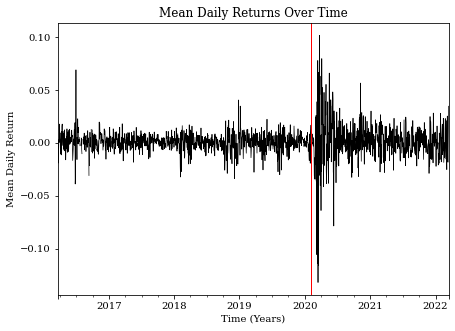

In [4]:
plt.rc('font', family='serif')
plt.rc('xtick')
plt.rc('ytick')

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)

returns_companies = df_returns.mean(axis=1)
returns_companies.plot(color="k", linewidth=0.7)

ax.set_xlabel('Time (Years)')
ax.set_ylabel('Mean Daily Return')
ax.set_title('Mean Daily Returns Over Time')

interval_borders = ["2020-02-01"] # TODO see if it makes sense to actually take first of Feb

for int_ in interval_borders:
    plt.axvline(x = int_, color = 'red', label = 'DD Event time', linewidth = 1)

plt.savefig(DATA_LOCATION +"visualisations/NYSE_daily_returns.jpg", dpi=600)
plt.show()


### Investigate Filing Trade Lag Times

Negative lag for 12 out of 29688 trades.
Lag longer than 21 days for 691 out of 29688 trades.
Eligible trades: 28985 out of 29688 trades.


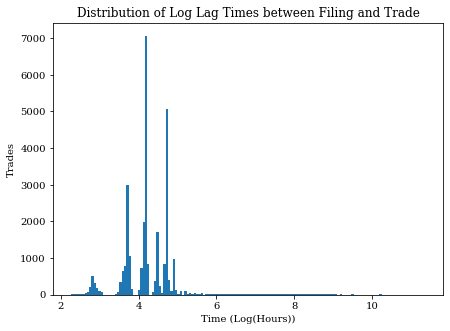

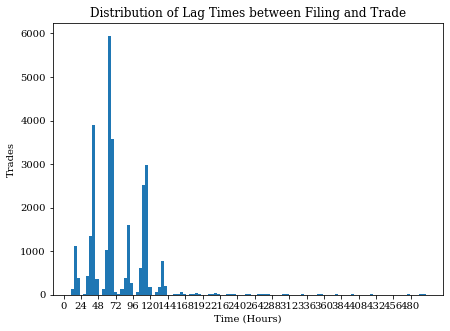

In [5]:
sum_returns = sum([x[0] for x in outputs], [])
filing_trade_lags = sum([x[1] for x in outputs], [])

lag_in_hours = np.asarray(filing_trade_lags)
negative_lag_mask = lag_in_hours < 0
positive_lag = lag_in_hours[~negative_lag_mask]
in_21_days = positive_lag < 21*24
relevant_lag = positive_lag[in_21_days]
print(f"Negative lag for {negative_lag_mask.sum()} out of {len(negative_lag_mask)} trades.")
print(f"Lag longer than 21 days for {len(positive_lag) - len(relevant_lag)} out of {len(negative_lag_mask)} trades.")
print(f"Eligible trades: {len(relevant_lag)} out of {len(negative_lag_mask)} trades.")

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)
plt.hist(np.log(positive_lag), bins="auto")
ax.set_xlabel('Time (Log(Hours))')
ax.set_ylabel('Trades')
ax.set_title('Distribution of Log Lag Times between Filing and Trade')

plt.savefig(DATA_LOCATION +"visualisations/log_transformed_lags.jpg", dpi=600)
plt.show()

without_outliers = positive_lag[positive_lag < 24*21]

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)
plt.hist(without_outliers, bins="auto")
plt.xticks(np.arange(0, max(without_outliers) + 1, 24))
ax.set_xlabel('Time (Hours)')
ax.set_ylabel('Trades')
ax.set_title('Distribution of Lag Times between Filing and Trade')

plt.savefig(DATA_LOCATION +"visualisations/lags_without_outliers.jpg", dpi=600)

# Get Market timeseries

In [6]:
end_time = datetime.datetime(2022, 3, 21, 23, 59, 59)
_end_time_unix = int(time.mktime(end_time.timetuple()))
print(_end_time_unix)

start_time = datetime.datetime(2016, 3, 21, 0, 0, 0)
_start_time_unix = int(time.mktime(start_time.timetuple()))

print(_start_time_unix)

if NAME == "Knudsen":
    _ticker = '%5EIXIC'
    
if NAME == "Niedermayer":
    _ticker = "%5Enya"
else:
    raise NotImplementedError
    
url = f'https://query1.finance.yahoo.com/v7/finance/download/{_ticker}?period1={_start_time_unix}&period2={_end_time_unix}&interval=1d&events=history&includeAdjustedClose=true'
market_timeseries = pd.read_csv(url)

market_timeseries = market_timeseries.set_index('Date')
market_timeseries.index = market_timeseries.index.astype('datetime64[ns]')

trading_days = market_timeseries.index
market_timeseries

1647903599
1458514800


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-03-21,10204.700195,10232.799805,10181.849609,10219.690430,10219.690430,3376600000
2016-03-22,10169.900391,10226.509766,10145.349609,10194.200195,10194.200195,3418460000
2016-03-23,10171.379883,10171.379883,10096.889648,10099.679688,10099.679688,3639510000
2016-03-24,10032.889648,10087.049805,10003.980469,10086.599609,10086.599609,3407720000
2016-03-28,10105.120117,10128.900391,10065.379883,10106.440430,10106.440430,2809090000
...,...,...,...,...,...,...
2022-03-15,15694.349609,15914.929688,15694.349609,15895.669922,15895.669922,4331170000
2022-03-16,15895.669922,16262.549805,15895.669922,16261.500000,16261.500000,5002240000
2022-03-17,16261.500000,16483.669922,16212.570313,16483.580078,16483.580078,4174170000


In [7]:
# Define windows

#### Our data contains multiple companies. A single company contains multiple filings and each filing is an event

![alt text](assets/images/windows.png "Title")


'[alt' is not recognized as an internal or external command,
operable program or batch file.


In [8]:
## Constants defining how long both Estimation Window and Event Window are
### Probably also input parameters to a function call, as we need loops later...
L1_length = 100
L2_length = 40 # TODO +-20 days = 40 days, right?

# Demonstrate process for a single event

### Fix a company

In [9]:

logging.getLogger().setLevel(logging.DEBUG)
company_index = -11
company = companies[company_index]
print(company)
company_return = company.return_index_df
insider_data_df = pd.read_csv(_insider_location + company.ticker + '.csv', index_col=0, parse_dates=['FilingDate', 'TradeDate'])
# TODO maybe some data sanitisation in the creation of company objects start_date and end_date have different datatypes

Company(company_type='2574ZV', isin='US98980B1035', name='ZIPRECRUITER A', ticker='ZIP', start_date=Timestamp('2021-05-26 00:00:00'), end_date=datetime.datetime(2022, 3, 16, 0, 0), return_index_df=            ReturnIndex
Date                   
2021-05-26       100.00
2021-05-27        98.82
2021-05-28        99.57
2021-05-31        99.57
2021-06-01       109.24
...                 ...
2022-03-10        97.58
2022-03-11        93.70
2022-03-14        89.67
2022-03-15        92.89
2022-03-16        96.78

[211 rows x 1 columns])


### Fix an event

In [10]:
# This date will be moved to a loop
## Define which periods we are looking at.
event_index = -200
event_timestamp = insider_data_df.FilingDate.iloc[event_index].floor("d") 
print("event timestamp: ", event_timestamp)

event timestamp:  2021-12-28 00:00:00


### Technical Checks

In [11]:
data_checks.run(L1_length, L2_length, event_timestamp, company_return, market_timeseries)

### Determine T0, T1 and T2

In [12]:
T0_, T1_, T0, T1, T2 = determine_T0_T1_T2.run(L1_length, L2_length, event_timestamp, company_return, market_timeseries)

DEBUG:root:Found T1: 2021-11-29 00:00:00
DEBUG:root:Found T2: 2022-01-26 00:00:00
DEBUG:root:Found T0: 2021-07-08 00:00:00
DEBUG:root:------------------------------
DEBUG:root:Event occurred at             2021-12-28 00:00:00
DEBUG:root:Estimation Window (100 days): from 2021-07-08 00:00:00 to 2021-11-29 00:00:00
DEBUG:root:Event Window      ( 40 days): from 2021-11-29 00:00:00 to 2022-01-26 00:00:00


### Abnormal and Normal Returns

![alt text](assets/images/return_estimation.png "Title")

### Cut return timeseries into correct periods

In [13]:
windows = cut_timeseries.run(company_return, market_timeseries, T0_, T1, T1_, T2)
estimation_window_market_return, estimation_window_company_return, event_window_market_return, event_window_company_return = windows

DEBUG:root:shape before aggregating
DEBUG:root:# estimation_window_market_timeseries: (101, 6)
DEBUG:root:# estimation_window_company_timeseries: (103, 1)
DEBUG:root:# event_window_market_timeseries: (41, 6)
DEBUG:root:# event_window_company_timeseries: (43, 1)
DEBUG:root:shape after aggregating
DEBUG:root:# estimation_window_market_return: (102,)
DEBUG:root:# estimation_window_market_return: (102,)
DEBUG:root:# event_window_market_return: (42,)
DEBUG:root:# event_window_company_return: (42,)


### Calculate coefficients

In [14]:
alpha, beta = calculate_coefficients.run(estimation_window_market_return, estimation_window_company_return)

DEBUG:root:                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     11.44
Date:                Thu, 15 Sep 2022   Prob (F-statistic):            0.00103
Time:                        14:37:13   Log-Likelihood:                 209.89
No. Observations:                 102   AIC:                            -415.8
Df Residuals:                     100   BIC:                            -410.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.003      0.7

### The Abnormal Return
This is the last step of the whole process for one event

In [15]:
company_return = event_window_company_return
market_return = event_window_market_return
estimated_return = alpha + beta*market_return
abnormal_return = company_return - estimated_return
print(abnormal_return)

Date
2021-11-29   -0.004123
2021-11-30   -0.041165
2021-12-01   -0.011859
2021-12-02   -0.025141
2021-12-03   -0.055116
2021-12-06    0.003454
2021-12-07    0.017956
2021-12-08    0.015772
2021-12-09   -0.022500
2021-12-10   -0.023340
2021-12-13   -0.033331
2021-12-14   -0.028838
2021-12-15   -0.007283
2021-12-16   -0.059731
2021-12-17    0.011624
2021-12-20   -0.007290
2021-12-21    0.028136
2021-12-22   -0.006466
2021-12-23    0.003617
2021-12-24   -0.002397
2021-12-27   -0.000345
2021-12-28   -0.012568
2021-12-29   -0.015338
2021-12-30    0.028529
2021-12-31   -0.018945
2022-01-03   -0.002303
2022-01-04   -0.008448
2022-01-05   -0.067013
2022-01-06   -0.004320
2022-01-07    0.028852
2022-01-10    0.035028
2022-01-11    0.006570
2022-01-12   -0.024349
2022-01-13   -0.010355
2022-01-14   -0.024951
2022-01-17   -0.002397
2022-01-18    0.001798
2022-01-19   -0.038483
2022-01-20   -0.028796
2022-01-21   -0.041329
2022-01-24    0.012054
2022-01-25   -0.022942
dtype: float64


In [16]:
# TODO @Gunnar there is this market calendar package perhaps its nice for checks for trading/non trading days and such
#import pandas_market_calendars as mcal

# Create a calendar
#nyse = mcal.get_calendar('NYSE')

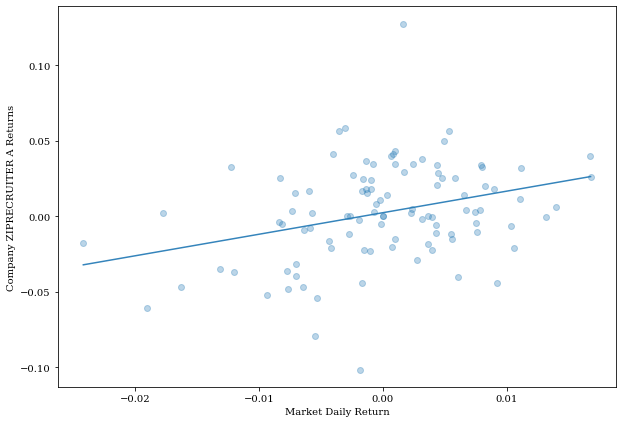

In [17]:
# I think you are the purest of garbage, and can thus be discarded
X = estimation_window_market_return.values
Y = estimation_window_company_return.values
X2 = np.linspace(X.min(), X.max(), 100)
Y_hat = X2 * beta + alpha
plt.figure(figsize=(10,7))
plt.scatter(X,Y, alpha = 0.3) # Plot the raw data
plt.xlabel('Market Daily Return')
plt.ylabel(f'Company {company.name} Returns')
           
plt.plot(X2, Y_hat, alpha = 0.9)
plt.show()


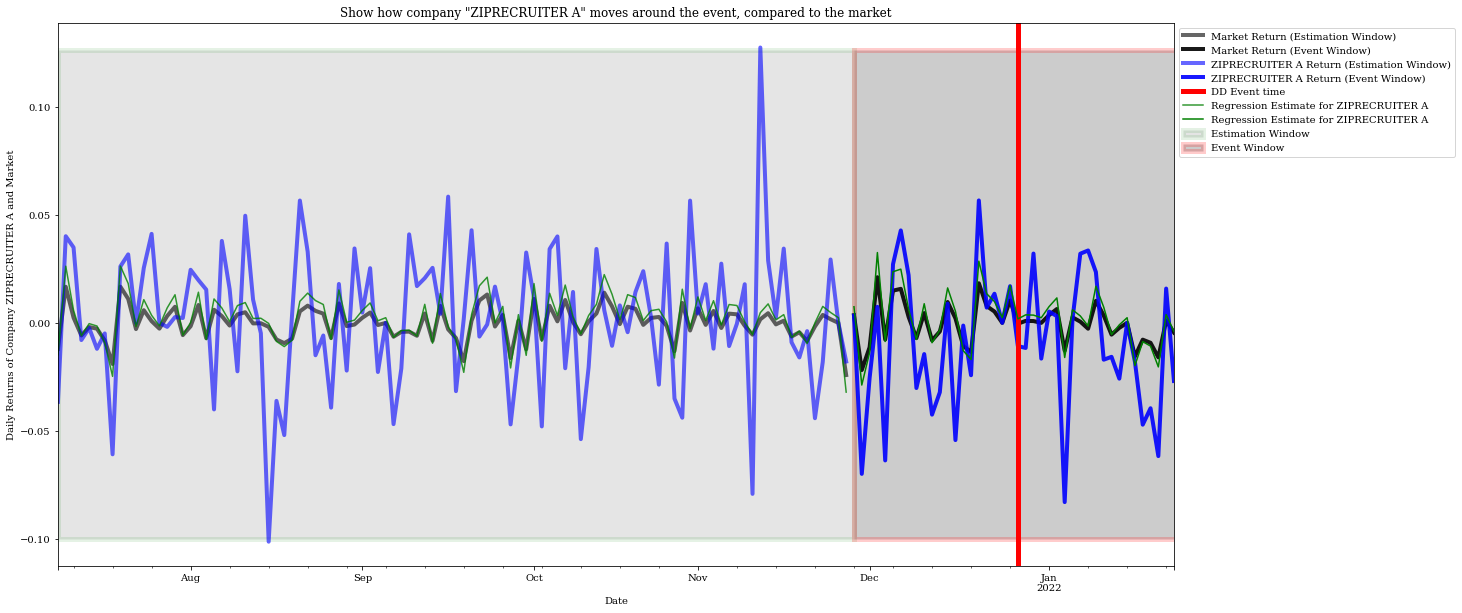

I'm impressed! It looks like a five-year-old drew this plot in paint


In [18]:
Company_name = company.name

# Estimations
est_estimation = estimation_window_market_return * beta + alpha
est_event = event_window_market_return * beta + alpha

plt.figure(figsize=(20,10))
estimation_window_market_return.plot(color = 'black', alpha = 0.6, linewidth=4, label = 'Market Return (Estimation Window)')
event_window_market_return.plot(color = 'black', alpha = 0.9, linewidth=4, label = 'Market Return (Event Window)')

estimation_window_company_return.plot(color = 'blue', alpha = 0.6, linewidth = 4, label = f'{Company_name} Return (Estimation Window)')
event_window_company_return.plot(color = 'blue', alpha = 0.9, linewidth = 4, label = f'{Company_name} Return (Event Window)')

plt.axvline(x = event_timestamp, color = 'red', label = 'DD Event time', linewidth = 5)
plt.ylabel(f'Daily Returns of Company {Company_name} and Market')
est_estimation.plot(color = 'green', label = f'Regression Estimate for {Company_name}', alpha = 0.8)
est_event.plot(color = 'green', label = f'Regression Estimate for {Company_name}', alpha = 1)

plt.axvspan(T0, T1, ymin = 0.05, ymax = 0.95, facecolor='black', alpha=0.1, label = 'Estimation Window', edgecolor='g', linewidth=5)
plt.axvspan(T1, T2, ymin = 0.05, ymax = 0.95, facecolor='black', alpha=0.2, label = 'Event Window', edgecolor='r', linewidth=5)
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')

plt.title(f'Show how company "{Company_name}" moves around the event, compared to the market')
plt.show()
print("I'm impressed! It looks like a five-year-old drew this plot in paint")


# Macro Analysis

### Now that we have seen the process for one single filing, let us do the same for all filings in all companies


In [19]:
from source.data_checks import DataSizeException
logging.getLogger().setLevel(logging.ERROR)
multiind, data = [], []

# this is the interval where filings are interesting to us
earliest_timestamp = pd.Timestamp("2018-01-01")
latest_timestamp = pd.Timestamp("2021-12-31")
n_companies = len(companies)
for j in range(len(companies))[-50:]: #TODO
    company = companies[j]
    company_return = company.return_index_df
    insider_data_df = pd.read_csv(_insider_location + company.ticker + '.csv', index_col=0, parse_dates=['FilingDate', 'TradeDate'])
    
    
    n_filings = len(insider_data_df)
    for i in insider_data_df.FilingDate.index:
        print("\n\n\n\n\n\n")
        print(f"working on company {j}/{n_companies} named {company.name}, filing {i}/{n_filings}")
        print(10*"*")
        filing_date = insider_data_df.FilingDate[i]
        
        event_timestamp = filing_date.floor("d")

        # if the timestamp is too early or too late we skip
        if event_timestamp < earliest_timestamp or event_timestamp > latest_timestamp:
            print("skipping, filing is too early or too late")
            continue

        # do the process for one filing
        try: 
            data_checks.run(L1_length, L2_length, event_timestamp, company_return, market_timeseries)
        except DataSizeException as exc:
            print(exc)
            continue
            
        T0_, T1_, T0, T1, T2 = determine_T0_T1_T2.run(L1_length, L2_length, event_timestamp, company_return, market_timeseries)
        windows = cut_timeseries.run(company_return, market_timeseries, T0_, T1, T1_, T2)
        estimation_window_market_return, estimation_window_company_return, event_window_market_return, event_window_company_return = windows
        alpha, beta = calculate_coefficients.run(estimation_window_market_return, estimation_window_company_return)

        abnormal_return = event_window_company_return - alpha - beta*event_window_market_return
        
        multiind.append((company.ticker, i, insider_data_df.TradeType[i]))
        data.append(abnormal_return)









working on company 2122/2171 named WORKIVA 'A', filing 0/416
**********
skipping, filing is too early or too late







working on company 2122/2171 named WORKIVA 'A', filing 1/416
**********
skipping, filing is too early or too late







working on company 2122/2171 named WORKIVA 'A', filing 2/416
**********
skipping, filing is too early or too late







working on company 2122/2171 named WORKIVA 'A', filing 3/416
**********
skipping, filing is too early or too late







working on company 2122/2171 named WORKIVA 'A', filing 4/416
**********
skipping, filing is too early or too late







working on company 2122/2171 named WORKIVA 'A', filing 5/416
**********
skipping, filing is too early or too late







working on company 2122/2171 named WORKIVA 'A', filing 6/416
**********
skipping, filing is too early or too late







working on company 2122/2171 named WORKIVA 'A', filing 7/416
**********
skipping, filing is too early or too late







working on company 2122/2

KeyError: Timestamp('2021-04-02 00:00:00')

In [ ]:
df_abnormal_returns = pd.DataFrame.from_records([d.reset_index(drop=True) for d in data])
df_abnormal_returns.index = pd.MultiIndex.from_tuples(multiind, names=["Company", "i", "TradeType"])
df_abnormal_returns

### next cell is for testing

In [ ]:
# testing for single company and filing
c = 2122
f = 32


company = companies[c]
company_return = company.return_index_df
insider_data_df = pd.read_csv(_insider_location + company.ticker + '.csv', index_col=0, parse_dates=['FilingDate', 'TradeDate'])
filing_date = insider_data_df.FilingDate[f]
event_timestamp = filing_date.floor("d")
print(insider_data_df.iloc[f])
print(insider_data_df.iloc[f+1])

try: 
    data_checks.run(L1_length, L2_length, event_timestamp, company_return, market_timeseries)
except DataSizeException as exc:
    print(exc)

T0_, T1_, T0, T1, T2 = determine_T0_T1_T2.run(L1_length, L2_length, event_timestamp, company_return, market_timeseries)
#params = {"company_return":company_return, "market_timeseries":market_timeseries, "T0_":T0_, "T1":T1, "T1_":T1_, "T2":T2}
#with open('tests/arguments/cut_timeseries.pickle', 'wb') as f:
#    pickle.dump(params, f)

windows = cut_timeseries.run(company_return, market_timeseries, T0_, T1, T1_, T2)
estimation_window_market_return, estimation_window_company_return, event_window_market_return, event_window_company_return = windows
alpha, beta = calculate_coefficients.run(estimation_window_market_return, estimation_window_company_return)

abnormal_return = event_window_company_return - alpha - beta*event_window_market_return
print(abnormal_return)

In [ ]:
estimation_window_market_return.fillna(method="bfill")

In [ ]:
### For estimating alphas and betas
estimation_window_index_market = (market_timeseries.index >= T0_) & (market_timeseries.index < T1)
estimation_window_index_company = (company_return.index >= T0_) & (company_return.index < T1)

estimation_window_market_timeseries = market_timeseries[estimation_window_index_market]
estimation_market_count = estimation_window_market_timeseries.shape[0]

estimation_window_company_timeseries = company_return[estimation_window_index_company]
estimation_company_count = estimation_window_company_timeseries.shape[0]

## Event-Window
event_window_index_market = (market_timeseries.index >= T1_) & (market_timeseries.index < T2)
event_window_index_company = (company_return.index >= T1_) & (company_return.index < T2)

event_window_market_timeseries = market_timeseries[event_window_index_market]
event_market_count = event_window_market_timeseries.shape[0]

event_window_company_timeseries = company_return[event_window_index_company]
event_company_count = event_window_company_timeseries.shape[0]

logging.debug('shape before aggregating')
logging.debug(f'# estimation_window_market_timeseries: {estimation_window_market_timeseries.shape}')
logging.debug(f'# estimation_window_company_timeseries: {estimation_window_company_timeseries.shape}')
logging.debug(f'# event_window_market_timeseries: {event_window_market_timeseries.shape}')
logging.debug(f'# event_window_company_timeseries: {event_window_company_timeseries.shape}')


In [ ]:
estimation_window_market_return

In [ ]:


# Unify indexing, so that both contain same amount of trading days.
if (estimation_company_count > estimation_market_count):
    idx = estimation_window_company_timeseries.index
    estimation_window_market_timeseries = estimation_window_market_timeseries.reindex(idx, fill_value = np.NaN)
    # Fill missing with previous observation
    estimation_window_market_timeseries['Adj Close'] = estimation_window_market_timeseries['Adj Close'].fillna(method='ffill')
    estimation_window_market_timeseries['Adj Close'] = estimation_window_market_timeseries['Adj Close'].fillna(method='bfill')



In [ ]:
if (estimation_market_count > estimation_company_count):
    idx = estimation_window_market_timeseries.index
    estimation_window_company_timeseries = estimation_window_company_timeseries.reindex(idx, fill_value = np.NaN)
    # Fill missing with previous observation
    estimation_window_company_timeseries['ReturnIndex'] = estimation_window_company_timeseries['ReturnIndex'].fillna(method='ffill')
    estimation_window_company_timeseries['ReturnIndex'] = estimation_window_company_timeseries['ReturnIndex'].fillna(method='bfill')


# Unify indexing, so that both contain same amount of trading days.
if (event_company_count > event_market_count):
    idx = event_window_company_timeseries.index
    event_window_market_timeseries = event_window_market_timeseries.reindex(idx, fill_value = np.NaN)
    # Fill missing with previous observation
    event_window_market_timeseries['Adj Close'] = event_window_market_timeseries['Adj Close'].fillna(method='ffill')
    event_window_market_timeseries['Adj Close'] = event_window_market_timeseries['Adj Close'].fillna(method='bfill')
if (event_market_count > event_company_count):
    idx = event_window_market_timeseries.index
    event_window_company_timeseries = event_window_company_timeseries.reindex(idx, fill_value = np.NaN)
    # Fill missing with previous observation
    event_window_company_timeseries['ReturnIndex'] = event_window_company_timeseries['ReturnIndex'].fillna(method='ffill')
    event_window_company_timeseries['ReturnIndex'] = event_window_company_timeseries['ReturnIndex'].fillna(method='bfill')

In [ ]:

# Calculate percentage returns
estimation_window_market_return = estimation_window_market_timeseries['Adj Close'].pct_change()
estimation_window_company_return = estimation_window_company_timeseries['ReturnIndex'].pct_change()

event_window_market_return = event_window_market_timeseries['Adj Close'].pct_change()
event_window_company_return = event_window_company_timeseries['ReturnIndex'].pct_change()

## Remove the fake first date
estimation_window_market_return = estimation_window_market_return.iloc[1:]
estimation_window_company_return = estimation_window_company_return.iloc[1:]

event_window_market_return = event_window_market_return.iloc[1:]
event_window_company_return = event_window_company_return.iloc[1:]

logging.debug('shape after aggregating')
logging.debug(f'# estimation_window_market_return: {estimation_window_market_return.shape}')
logging.debug(f'# estimation_window_market_return: {estimation_window_market_return.shape}')
logging.debug(f'# event_window_market_return: {event_window_market_return.shape}')
logging.debug(f'# event_window_company_return: {event_window_company_return.shape}')

In [ ]:
id = company_return.index.get_loc(event_timestamp)
print(company_return.iloc[id])

id = market_timeseries.index.get_loc(event_timestamp - datetime.timedelta(1))
print(market_timeseries.iloc[id])

### Mean Abnormal Returns by Trade Type

In [ ]:
df_abnormal_returns.groupby(level=[2]).mean().transpose().plot()